<a href="https://colab.research.google.com/github/ragabhumi/Praktikum_Magnetbumi/blob/main/Pemodelan_Magnet_Bumi_RTE_RTP_FHD_SVD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**PEMODELAN DATA MAGNET BUMI - 2024**

**Pemodelan Magnet Bumi menggunakan Data Global**

oleh: Yosi Setiawan

Diklat Geofisika Potensial, 5 September 2024

Pada praktik pengolahan data magnet bumi ini, software yang digunakan adalah Fatiando a Terra (Uieda et.al., 2013) untuk analisis data magnet bumi, dan PyGMT (Uieda et.al., 2023) untuk visualisasi yang keduanya berbasis Python. Pengolahan dilakukan di Google Colab untuk memudahkan akses terhadap program dan data yang digunakan tanpa harus menginstall di komputer atau laptop masing-masing peserta.

Pada bagian ini, data yang akan digunakan adalah **data model magnet bumi EMAG2v3**.

Langkah pertama yang harus dilakukan adalah menginstal CondaColab di Google Colab di akun Google masing-masing. Tekan tombol **Run cell** di sebelah kiri setiap cell atau tekan tombol Ctrl+Enter. Tunggu hingga proses instalasi selesai. Jika muncul notifikasi **Your session crashed for an unknown reason.**, abaikan dan tutup notifikasi tersebut.

In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install_from_url("https://github.com/conda-forge/miniforge/releases/download/25.3.1-0/Miniforge3-Linux-x86_64.sh")

Selanjutnya, cek apakah instalasi CondaColab telah berhasil. Pastikan hasil yang muncul adalah **Everything looks OK!**.

In [ ]:
import condacolab
condacolab.check()

Langkah berikutnya adalah menginstal modul-modul Python yang diperlukan. Proses ini memerlukan waktu yang agak lama. Tunggulah hingga proses selesai.

In [ ]:
# %pip install geopandas

Download data patahan yang akan digunakan.

In [ ]:
import geopandas as gpd
# Download
url_coast = 'https://raw.githubusercontent.com/ragabhumi/Praktikum_Magnetbumi/refs/heads/main/data/jatim/jatim_utm.geojson'
url_faults = 'https://raw.githubusercontent.com/ragabhumi/Praktikum_Magnetbumi/refs/heads/main/data/jatim/jatim_fault_utm.geojson'
url_thrust = 'https://raw.githubusercontent.com/ragabhumi/Praktikum_Magnetbumi/refs/heads/main/data/sumbar/sumbar_thrust_utm.geojson'
url_subduksi = 'https://raw.githubusercontent.com/ragabhumi/Praktikum_Magnetbumi/refs/heads/main/data/jatim/jatim_subduksi_utm.geojson'

gdf_coast = gpd.read_file(url_coast)
gdf_faults = gpd.read_file(url_faults)
gdf_thrust = gpd.read_file(url_thrust)
gdf_subduksi = gpd.read_file(url_subduksi)

Instal modul-modul Python lainnya

In [ ]:
!mamba install verde harmonica boule pooch pygmt pandas xarray pyigrf xrft rioxarray ensaio numpy==1.26.4 cffi==1.17.0 simpeg discretize

Import modul-modul Python yang akan digunakan

In [ ]:
# The standard Python science stack
import numpy as np
import pandas as pd
import xarray as xr
import rioxarray as rxr
import xrft
import datetime
from scipy import signal
from google.colab import files
from scipy.fftpack import fft2, ifft2, fftshift
from scipy.interpolate import griddata
import scipy.fft as fft
import scipy.stats as stats
from scipy.ndimage import median_filter
import io
import pathlib
import math

# For IGRF correction
import pyIGRF

# Plotting maps using GMT
import pygmt

# The Fatiando stack
import pooch
import verde as vd
import boule as bl
import harmonica as hm

# For projections (wrapped for Proj)
import pyproj
from pyproj import Geod
import os

# SimPEG functionality
import simpeg
from simpeg.potential_fields import magnetics
from simpeg.utils import plot2Ddata, model_builder, download
from simpeg import (
    maps,
    data,
    data_misfit,
    inverse_problem,
    regularization,
    optimization,
    directives,
    inversion,
    survey
)

# discretize functionality
from discretize import TensorMesh, TreeMesh
from discretize.utils import active_from_xyz

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams.update({"font.size": 14})

Upload data magnet yang akan digunakan.

In [ ]:
!rm "EMAG2_V3_clip.csv"
path_mag = files.upload()
print(path_mag)

Selanjutnya, data model magnet bumi dengan format csv kita parsing menggunakan modul Pandas dan diberikan nama untuk setiap kolomnya.

In [ ]:
data_mag = pd.read_csv(io.BytesIO(path_mag['EMAG2_V3_clip.csv']), sep=',', names=['i', 'j', 'Longitude', 'Latitude', 'Sealevel', 'UpCont', 'Code', 'Error'])
data_mag

Pada data yang kita gunakan, terdapat beberapa titik yang datanya ambigu maupun titik yang tidak ada data. Titik yang datanya ambigu diberikan kode 888 dan nilainya -888 nT, sedangkan titik yang tidak ada data diberikan kode 999 dan nilainya 99999 nT. Sehingga titik-titik tersebut harus kita hilangkan.

In [ ]:
data_mag = data_mag[(data_mag['Code'] != 888) & (data_mag['Code'] != 999)]
data_mag

Tambahkan koordinat UTM

In [ ]:
myProj = pyproj.Proj("+proj=utm +zone=49 +south +ellps=WGS84 +datum=WGS84 +units=m +no_defs")
data_mag.loc[:, 'UTMX'], data_mag.loc[:, 'UTMY'] = myProj(data_mag['Longitude'], data_mag['Latitude'], inverse=False)
data_mag

**Tambahkan nilai IGRF untuk mendapatkan nilai TMI**

In [ ]:
IGRF = []
for i in range(len(data_mag)):
    #myProj = pyproj.Proj("+proj=merc +ellps=WGS84 +datum=WGS84 +no_defs")
    #lon_,lat_ = myProj(data['Longitude'].iloc[i], data['Latitude'].iloc[i], inverse=True)
    #IGRF = IGRF + [pyIGRF.igrf_value(lat_, lon_, 4, 2017.5)[-1]]
    IGRF = IGRF + [pyIGRF.igrf_value(data_mag['Latitude'].iloc[i], data_mag['Longitude'].iloc[i], 4, 2017.5)[6]]
data_mag['IGRF'] = IGRF

Tambahkan nilai TMI (IGRF + anomali)

In [ ]:
data_mag['TMI'] =  data_mag['IGRF'] + data_mag['UpCont']
data_mag['Elevasi_UpCont'] = 4000
data_mag['Elevasi_SeaLevel'] = 0
data_mag

Download data

In [ ]:
data_mag.to_csv('Data.csv')
files.download('Data.csv')

Kita tampilkan titik-titik grid model magnet dalam koordinat UTM.

In [ ]:
# Kita atur batas koordinat sesuai dengan batasan data kita
lon_min = data_mag['UTMX'].min()
lon_max = data_mag['UTMX'].max()
lat_min = data_mag['UTMY'].min()
lat_max = data_mag['UTMY'].max()

fig = pygmt.Figure()
fig.basemap(projection='X20c', region=[lon_min, lon_max, lat_min, lat_max], frame=["WSne", "xaf+lUTMX", "yaf+lUTMY"])
#fig.coast(resolution='f', shorelines='2p,black,solid')

fig.plot(x=data_mag['UTMX'], y=data_mag['UTMY'],
    style="c0.1c",
    fill="red",
    pen="faint")
fig.plot(gdf_coast, pen='1.5p')
fig.plot(gdf_faults, pen='3p')
fig.plot(gdf_thrust, pen='3p')
fig.plot(gdf_subduksi, pen='2p', style="~d1c:+st0.4c+gred+p0.5p,black+n0.1c")
fig.show()

Menampilkan peta model anomali magnet bumi dalam bentuk kontur. Pertama, kita interpolasikan dahulu data txt menjadi data grid dengan spasi 1 km.

In [ ]:
spacing = 1000 # dalam meter
pre_data = pygmt.blockmean(x=data_mag['UTMX'], y=data_mag['UTMY'], z=data_mag['UpCont'], region=[data_mag['UTMX'].min(), data_mag['UTMX'].max(), data_mag['UTMY'].min(), data_mag['UTMY'].max()], spacing=str(spacing))
data_grid = pygmt.surface(pre_data, region=[data_mag['UTMX'].min(), data_mag['UTMX'].max(), data_mag['UTMY'].min(), data_mag['UTMY'].max()], spacing=str(spacing))
data_grid.rio.write_crs("epsg:32749", inplace=True)

Kita tampilkan peta konturnya menggunakan PyGMT.

In [ ]:
fig = pygmt.Figure()
scale = np.quantile(np.abs(data_grid), 0.995)
pygmt.makecpt(cmap="seis+h", reverse=True, series=[-scale, scale], background=True)
fig.basemap(projection='X20', region=[lon_min, lon_max, lat_min, lat_max], frame=["WSne", "xaf+lUTMX", "yaf+lUTMY"])
fig.grdimage(grid=data_grid, cmap=True)
fig.plot(gdf_coast, pen='1.5p')
fig.plot(gdf_faults, pen='3p')
fig.plot(gdf_thrust, pen='3p')
fig.plot(gdf_subduksi, pen='2p', style="~d1c:+st0.4c+gred+p0.5p,black+n0.1c")
fig.grdcontour(grid=data_grid, levels=20, annotation=20, pen='0.4p')

# Add colorbar
fig.colorbar(frame='af+lPeta Anomali Medan Magnet (nT)', position="JBC+h+o0/2c+e")
fig.show()

Download Data

In [ ]:
# Download file GeoTIFF
data_grid_clip = data_grid.rio.clip_box(minx=lon_min, miny=lat_min, maxx=lon_max, maxy=lat_max)

data_grid_clip.rio.to_raster("Anomali_Total.tiff")
files.download('Anomali_Total.tiff')

# Download file CSV
data_df = data_grid_clip.to_dataframe(name='Anomali_Total')
data_df.to_csv('Anomali_Total.csv')
files.download('Anomali_Total.csv')

**1. Reduksi ke Ekuator**

Kita lakukan transformasi reduksi ke ekuator.

In [ ]:
# Merubah nama kolom X dan Y
#data_grid.rio.write_crs('+proj=lonlat', inplace=True)
#utm_grid = data_grid.rio.reproject(CRS)
data_grid = data_grid.rename({'x':'easting', 'y':'northing'})
#utm_grid

# Mengambil data magnetik dari grid (xarray format)
magnetic_anomaly = data_grid.values

# Parameter magnetik lokal untuk ekuator
inclination = np.radians(-31.893)  # Hampir horizontal di ekuator
declination = np.radians(0.806)  # Sesuaikan dengan lokasi

# Periksa dan ganti nilai NaN pada data asli
magnetic_anomaly = np.nan_to_num(magnetic_anomaly, nan=0.0, posinf=0.0, neginf=0.0)

# Transformasi Fourier dari data anomali magnetik
anomaly_fft = fft2(magnetic_anomaly)

# Mendapatkan dimensi grid
ny, nx = magnetic_anomaly.shape
dx = data_grid['easting'].diff('easting').mean().values  # Resolusi grid (longitude)
dy = data_grid['northing'].diff('northing').mean().values    # Resolusi grid (latitude)

# Membuat array frekuensi dalam arah x dan y
kx = np.fft.fftfreq(nx, dx) * 2 * np.pi
ky = np.fft.fftfreq(ny, dy) * 2 * np.pi
kx, ky = np.meshgrid(kx, ky)

# Frekuensi radial
kr = np.sqrt(kx**2 + ky**2)

# Kalkulasi filter RTE
k1 = np.cos(inclination) + 1j * np.sin(inclination) * (kx * np.cos(declination) + ky * np.sin(declination)) / (kr + np.finfo(float).eps)
rte_filter = np.abs(k1)

# Aplikasi filter RTE pada domain frekuensi
rte_anomaly_fft = anomaly_fft * rte_filter

# Transformasi balik Fourier untuk mendapatkan data RTE dalam domain spasial
rte_grid_val = np.real(ifft2(rte_anomaly_fft))

# Membuat DataArray baru dengan hasil RTE menggunakan xarray
rte_grid = xr.DataArray(rte_grid_val, dims=data_grid.dims, coords=data_grid.coords)

Menampilkan peta anomali reduksi ke ekuator.

In [ ]:
fig = pygmt.Figure()
scale = np.quantile(np.abs(rte_grid), 0.995)
pygmt.makecpt(cmap="seis+h", reverse=True, series=[-scale, scale], background=True)
fig.basemap(projection='X20', region=[lon_min, lon_max, lat_min, lat_max], frame=["WSne", "xaf+lUTMX", "yaf+lUTMY"])
fig.grdimage(grid=rte_grid, cmap=True)
fig.plot(gdf_coast, pen='1.5p')
fig.plot(gdf_faults, pen='3p')
fig.plot(gdf_thrust, pen='3p')
fig.plot(gdf_subduksi, pen='2p', style="~d1c:+st0.4c+gred+p0.5p,black+n0.1c")
fig.grdcontour(grid=rte_grid, levels=20, annotation=20, pen='0.4p')

# Add colorbar
fig.colorbar(frame='af+lPeta Reduksi ke Ekuator (nT)', position="JBC+h+o0/2c+e")
fig.show()

**Download data RTE**

In [ ]:
# Download file GeoTIFF
rte_grid_clip = rte_grid.rio.clip_box(minx=lon_min, miny=lat_min, maxx=lon_max, maxy=lat_max)

rte_grid_clip = rte_grid_clip.rename({'easting':'x', 'northing':'y'})
rte_grid_clip.rio.to_raster("RTE.tiff")
files.download('RTE.tiff')

# Download file CSV
RTE_df = rte_grid_clip.to_dataframe(name='RTE')
RTE_df.to_csv('RTE.csv')
files.download('RTE.csv')

**2. Downward Continuation**

Data UpCont berada di ketinggian 4 km, sehingga perlu dilakukan downward continuation agar data berada di ketinggan 0 km.


In [ ]:
try:
    rte_grid.easting.name = 'easting'
    rte_grid.northing.name = 'northing'
except:
    rte_grid = rte_grid.rename({'x':'easting', 'y':'northing'})

def upward_continuation(data, dz, dx, dy):
    """
    Melakukan upward continuation menggunakan transformasi Fourier.

    Parameters:
    - data: numpy.ndarray, data medan potensial (misalnya, anomali gravitasi atau magnetik)
    - dz: float, jarak upward continuation (positif)
    - dx: float, interval grid dalam arah x
    - dy: float, interval grid dalam arah y

    Returns:
    - data_uc: numpy.ndarray, data setelah upward continuation
    """
    ny, nx = data.shape
    kx = fft.fftfreq(nx, d=dx) * 2 * np.pi
    ky = fft.fftfreq(ny, d=dy) * 2 * np.pi
    KX, KY = np.meshgrid(kx, ky)
    k = np.sqrt(KX**2 + KY**2)

    # Transformasi Fourier dari data
    data_fft = fft.fft2(data)

    # Filter upward continuation
    filter_uc = np.exp(-k * dz)

    # Terapkan filter pada domain Fourier
    data_uc_fft = data_fft * filter_uc

    # Transformasi balik ke domain spasial
    data_uc = np.real(fft.ifft2(data_uc_fft))

    return data_uc

def downward_continuation(data_xr, dz, h, order=8, crop_size=0.1):
    """
    Melakukan downward continuation menggunakan metode kombinasi linear
    dari hasil upward continuation pada beberapa level.

    Parameters:
    - data_xr: xarray.DataArray, data medan potensial pada ketinggian awal
    - dz: float, jarak downward continuation (misalnya, -4000 m untuk EMAG2V3)
    - h: float, jarak antar level upward continuation (misalnya, 1000 m)
    - order: int, orde deret Taylor (default=8)
    - crop_size: float, proporsi area tepi yang akan dipotong (default=10%)

    Returns:
    - data_xr_dc: xarray.DataArray, data setelah downward continuation dan cropping
    """
    # Ambil nilai grid dan koordinat dari xarray
    easting = data_xr.easting.values
    northing = data_xr.northing.values
    data = data_xr.values

    # Resolusi grid
    dx = np.abs(easting[1] - easting[0])
    dy = np.abs(northing[1] - northing[0])

    # Hitung jumlah level upward continuation yang diperlukan
    nn = int(np.abs(dz) / h)
    if nn > order:
        raise ValueError("Jumlah level upward continuation melebihi orde deret Taylor.")

    # Lakukan upward continuation pada beberapa level
    uc_levels = [data]
    for i in range(1, order + 1):
        uc = upward_continuation(data, i * h, dx, dy)
        uc_levels.append(uc)

    # Koefisien untuk kombinasi linear (sesuai dengan binomial coefficients)
    coeffs = np.array([(-1)**i * math.comb(order, i) for i in range(order + 1)])

    # Lakukan kombinasi linear untuk downward continuation
    data_dc = sum(c * uc for c, uc in zip(coeffs, uc_levels))

    # Lakukan iterasi downward continuation sesuai dengan jumlah level
    for _ in range(nn):
        data_dc = sum(c * uc for c, uc in zip(coeffs, uc_levels))
        uc_levels = [data_dc] + uc_levels[:-1]

    # Crop bagian tepi untuk menghilangkan artefak FFT
    ny, nx = data_dc.shape
    crop_y = int(ny * crop_size)
    crop_x = int(nx * crop_size)

    data_dc_cropped = data_dc[crop_y:-crop_y, crop_x:-crop_x]

    # Crop koordinat juga
    easting_cropped = easting[crop_x:-crop_x]
    northing_cropped = northing[crop_y:-crop_y]

    # Simpan hasil dalam xarray.DataArray dengan koordinat yang telah dipotong
    data_xr_dc = xr.DataArray(data_dc_cropped, coords=[("northing", northing_cropped), ("easting", easting_cropped)])

    return data_xr_dc

# Contoh penggunaan dengan data EMAG2V3
dz = -4000  # Turunkan dari 4 km ke 0 km
h = 1000    # Jarak upward continuation per level dalam meter
order = 8   # Orde deret Taylor
crop_size = 0.01  # Hilangkan 1% data di tepi

# Lakukan downward continuation pada data xarray dengan cropping
downward_continued = downward_continuation(rte_grid, dz, h, order=order, crop_size=crop_size)

In [ ]:
fig = pygmt.Figure()
scale = np.quantile(np.abs(downward_continued), 0.995)
pygmt.makecpt(cmap="seis+h", reverse=True, series=[-scale, scale], background=True)
fig.basemap(projection='X20', region=[lon_min, lon_max, lat_min, lat_max], frame=["WSne", "xaf+lUTMX", "yaf+lUTMY"])
fig.grdimage(grid=downward_continued, cmap=True)
fig.plot(gdf_coast, pen='1.5p')
fig.plot(gdf_faults, pen='3p')
fig.plot(gdf_thrust, pen='3p')
fig.plot(gdf_subduksi, pen='2p', style="~d1c:+st0.4c+gred+p0.5p,black+n0.1c")
fig.grdcontour(grid=downward_continued, levels=200, annotation=200, pen='0.4p')

# Add colorbar
fig.colorbar(frame='af+lPeta Downward Continuation (nT)', position="JBC+h+o0/2c+e")
fig.show()

In [ ]:
# Download file GeoTIFF
downward_continued = downward_continued.rename({'easting':'x', 'northing':'y'})
downward_continued.rio.write_crs("epsg:32747", inplace=True)
downward_continued_clip = downward_continued.rio.clip_box(minx=lon_min, miny=lat_min, maxx=lon_max, maxy=lat_max)
downward_continued = downward_continued.rename({'x':'easting', 'y':'northing'})

downward_continued_clip.rio.to_raster("Downward.tiff")
files.download('Downward.tiff')

# Download file CSV
downward_continued_df = downward_continued_clip.to_dataframe(name='Downward')
downward_continued_df.to_csv('Downward.csv')
files.download('Downward.csv')

**3. Penentuan Anomali Regional**

Untuk mendapatkan anomali residual, kita tentukan dulu slice untuk dilakukan perhitungan analisis spektral. Analisis spektral dilakukan untuk menentukan estimasi kedalaman sumber anomali yang mengendalikan variasi suseptibilitas. Analisis ini dilakukan per data sayatan pada setiap sumbu koordinat. Analisis spektral dilakukan dengan menerapkan transformasi Fourier anomali TMI yang sudah dilakukan RTE di setiap sayatan. Algoritma proses transformasi ini berasal dari nilai anomali TMI yang diamati pada bidang horizontal. Untuk mendapatkan hubungan langsung antara amplitudo, bilangan gelombang, dan estimasi kedalaman sumber anomali, perhitungan logaritmik dilakukan pada spektrum amplitudo untuk menghasilkan persamaan linier.

In [ ]:
fig = pygmt.Figure()
scale = np.quantile(np.abs(downward_continued), 0.995)
pygmt.makecpt(cmap="seis+h", reverse=True, series=[-scale, scale], background=True)
fig.basemap(projection='X20', region=[lon_min, lon_max, lat_min, lat_max], frame=["WSne", "xaf+lUTMX", "yaf+lUTMY"])
fig.grdimage(grid=downward_continued, cmap=True)
fig.plot(gdf_coast, pen='1.5p')
fig.plot(gdf_faults, pen='3p')
fig.plot(gdf_thrust, pen='3p')
fig.plot(gdf_subduksi, pen='2p', style="~d1c:+st0.4c+gred+p0.5p,black+n0.1c")
fig.grdcontour(grid=downward_continued, levels=200, annotation=200, pen='0.4p')

# Kita atur agar ada 6 slice vertikal dan 4 slice horizontal
ver_slice = 6
hor_slice = 6

for i in range(ver_slice):
    min_lon = lon_min + (i + 1) * (lon_max - lon_min) / (ver_slice + 1)
    max_lon = min_lon
    max_lat = lat_max
    min_lat = lat_min
    lon_inc = 1000 # interval sampling longitude
    lat_inc = 1000 # interval sampling latitude

    # Slice data
    x = xr.DataArray([min_lon]*(int((max_lat-min_lat)/lat_inc) + 1), dims=['location'])
    y = xr.DataArray(np.arange(min_lat, max_lat, lat_inc).tolist(), dims=['location'])
    globals()['slice_v%s' % (i+1)] = downward_continued.sel(easting=x, northing=y, method='nearest')

    fig.plot(x=[min_lon, max_lon], y=[min_lat, max_lat], pen='2p,red')
    fig.text(text='v' + str(i + 1), x=min_lon, y=max_lat, font='14p', offset='0/0.5', no_clip=True)

for j in range(hor_slice):
    max_lon = lon_max
    min_lon = lon_min
    min_lat = lat_min + (j + 1) * (lat_max - lat_min) / (hor_slice + 1)
    max_lat = min_lat
    lon_inc = 1000 # interval sampling longitude
    lat_inc = 1000 # interval sampling latitude

    # Slice data
    x = xr.DataArray(np.arange(min_lon, max_lon, lon_inc).tolist(), dims=['location'])
    y = xr.DataArray([min_lat]*(int((max_lon-min_lon)/lon_inc) + 1), dims=['location'])
    globals()['slice_h%s' % (j+1)] = downward_continued.sel(easting=x, northing=y, method='nearest')

    fig.plot(x=[min_lon, max_lon], y=[min_lat, max_lat], pen='2p,red')
    fig.text(text='h' + str(j + 1), x=max_lon, y=max_lat, font='14p', offset='0.5/0', no_clip=True)

# Add colorbar
fig.colorbar(frame='af+lPeta Downward Continuation (nT)', position="JBC+h+o0/2c+e")
fig.show()

Tampilkan hasil slicenya

In [ ]:
for i in range(ver_slice):
    mag_data = globals()['slice_v%s' % (i+1)].to_numpy()
    lat_data = globals()['slice_v%s' % (i+1)].northing.to_numpy()
    lon_data = globals()['slice_v%s' % (i+1)].easting.to_numpy()

    distance = []
    for ii in range(len(mag_data)):
        distance += [ii * spacing/1000]

    df = pd.DataFrame({'UTMX':lon_data, 'UTMY':lat_data, 'Jarak': distance, 'Mag': mag_data})

    fig = pygmt.Figure()
    fig.basemap(projection='X20/10', region=[min(df['Jarak'],), max(df['Jarak'],), min(df['Mag']), max(df['Mag'])],
                frame=["xafg+lJarak (km)",
                "yafg+lAnomali Magnetik (nT)",
                "WSen+tSlice v" + str(i+1)])
    fig.plot(x=df['Jarak'], y=df['Mag'], pen='2p')
    fig.show()

for i in range(hor_slice):
    mag_data = globals()['slice_h%s' % (i+1)].to_numpy()
    lat_data = globals()['slice_h%s' % (i+1)].northing.to_numpy()
    lon_data = globals()['slice_h%s' % (i+1)].easting.to_numpy()

    distance = []
    for ii in range(len(mag_data)):
        distance += [ii * spacing/1000]

    df = pd.DataFrame({'UTMX':lon_data, 'UTMY':lat_data, 'Jarak': distance, 'Mag': mag_data})

    fig = pygmt.Figure()
    fig.basemap(projection='X20/10', region=[min(df['Jarak'],), max(df['Jarak'],), min(df['Mag']), max(df['Mag'])],
                frame=["xafg+lJarak (km)",
                "yafg+lAnomali Magnetik (nT)",
                "WSen+tSlice h" + str(i+1)])
    fig.plot(x=df['Jarak'], y=df['Mag'], pen='2p')
    fig.show()

In [ ]:
df.to_csv('Slice_anomali.dat', sep=',', index=False, lineterminator='\r\n')
files.download('Slice_anomali.dat')

**Analisis spektrum**

In [ ]:
def analisa_spektrum(df, title):
    fftaa = np.fft.fft(df['Mag'])
    dx = len(df['Mag'])
    dk = 1/(0.5*dx)
    k = np.dot((2*np.pi/dx), np.arange(0,1,dk))
    ln_A = np.log(np.sqrt((np.real(fftaa))**2+(np.imag(fftaa))**2));

    fig = pygmt.Figure()
    fig.basemap(projection='X20/10', region=[min(k,), max(k,), min(ln_A[0:len(k)]), max(ln_A[0:len(k)])],
                frame=["xafg+lk",
                "yafg+llnA",
                "WSen+tSlice " + title])
    fig.plot(x=k, y=ln_A[0:len(k)], pen='black', style="c0.3c", fill='red')
    fig.show()
    return k, ln_A[0:len(k)]

for i in range(ver_slice):
    mag_data = globals()['slice_v%s' % (i+1)].to_numpy()

    distance = []
    for ii in range(len(mag_data)):
        distance += [ii * spacing/1000]

    df = pd.DataFrame({'Jarak': distance, 'Mag': mag_data})
    x, y = analisa_spektrum(df, 'v%s' % (i+1))

    df = pd.DataFrame({'slice_v%s_k'%eval(str(i+1)):x, 'slice_v%s_ln_A'%eval(str(i+1)):y})
    df.to_csv('slice_v%s.dat'%eval(str(i+1)), sep=',', index=False, lineterminator='\r\n')
    files.download('slice_v%s.dat'%eval(str(i+1)))

for i in range(hor_slice):
    mag_data = globals()['slice_h%s' % (i+1)].to_numpy()

    distance = []
    for ii in range(len(mag_data)):
        distance += [ii * spacing/1000]

    df = pd.DataFrame({'Jarak': distance, 'Mag': mag_data})
    x, y = analisa_spektrum(df, 'h%s' % (i+1))

    df = pd.DataFrame({'slice_h%s_k'%eval(str(i+1)):x, 'slice_h%s_ln_A'%eval(str(i+1)):y})
    df.to_csv('slice_h%s.dat'%eval(str(i+1)), sep=',', index=False, lineterminator='\r\n')
    files.download('slice_h%s.dat'%eval(str(i+1)))

Tentukan estimasi batas nilai cut off (Kc) dari masing-masing slice berdasarkan grafik untuk pemisahan regional dan residual

In [ ]:
v1 = 0.0018
v2 = 0.0018
v3 = 0.0018
v4 = 0.0015
v5 = 0.0018
v6 = 0.0016
h1 = 0.001
h2 = 0.001
h3 = 0.001
h4 = 0.001
h5 = 0.001
h6 = 0.001

Tentukan estimasi batas nilai cut off (Kc) dari masing-masing slice berdasarkan grafik untuk pemisahan residual dan noise

In [ ]:
v1_noise = 0.008
v2_noise = 0.009
v3_noise = 0.009
v4_noise = 0.009
v5_noise = 0.009
v6_noise = 0.009
h1_noise = 0.008
h2_noise = 0.008
h3_noise = 0.008
h4_noise = 0.008
h5_noise = 0.008
h6_noise = 0.008

Plot analisis spektrum dengan batas cutoff yang memisahkan anomali regional dan residual

In [ ]:
def analisa_spektrum_kc(df, title):
    fftaa = np.fft.fft(df['Mag'])
    dx = len(df['Mag'])
    dk = 1/(0.5*dx)
    k = np.dot((2*np.pi/dx), np.arange(0,1,dk))
    ln_A = np.log(np.sqrt((np.real(fftaa))**2+(np.imag(fftaa))**2));

    # Tentukan nilai cut off
    x_slipt_est = eval(title) # Regional - Residual
    x_slipt_est_noise = eval(title + '_noise') # Residual - Noise
    x = k
    y = ln_A[0:len(k)]

    x_split = x[x < x_slipt_est][-1] # --> Nilai Kc sebenarnya Regional - Residual
    x_split_noise = x[x < x_slipt_est_noise][-1] # --> Nilai Kc sebenarnya Residual - Noise

    # Pisahkan data sebelum dan sesudah batas
    x1, y1 = x[x <= x_split], y[x <= x_split]  # Data sebelum x_split
    x2, y2 = x[(x > x_split) & (x <= x_split_noise)], y[(x > x_split) & (x <= x_split_noise)]  # Data setelah x_split
    x3, y3 = x[x > x_split_noise], y[x > x_split_noise]  # Data setelah x_split

    # Lakukan regresi linier untuk masing-masing bagian
    slope1, intercept1, r_value1, _, _ = stats.linregress(x1, y1)
    slope2, intercept2, r_value2, _, _ = stats.linregress(x2, y2)
    slope3, intercept3, r_value3, _, _ = stats.linregress(x3, y3)

    # Buat nilai X untuk regresi linier
    x1_fit = np.linspace(min(x1), max(x1), 10)
    y1_fit = slope1 * x1_fit + intercept1

    x2_fit = np.linspace(min(x2), max(x2), 10)
    y2_fit = slope2 * x2_fit + intercept2

    x3_fit = np.linspace(min(x3), max(x3), 10)
    y3_fit = slope3 * x3_fit + intercept3

    # Buat figure dengan PyGMT
    fig = pygmt.Figure()
    fig.basemap(projection='X20/10', region=[min(k,), max(k,), min(ln_A[0:len(k)]), max(ln_A[0:len(k)])],
                frame=["xafg+lk",
                "yafg+llnA",
                "WSen+tSlice " + title])

    # Tambahkan scatter plot (Satu dataset, tetapi dengan warna berbeda sebelum dan setelah x_split)
    fig.plot(x=x1, y=y1, style="s0.3c", fill="red", pen="black")  # Data sebelum x_split
    fig.plot(x=x2, y=y2, style="c0.3c", fill="green", pen="black")  # Data setelah x_split
    fig.plot(x=x3, y=y3, style="t0.3c", fill="lightblue", pen="black")  # Data setelah x_split

    # Tambahkan garis batas pemisah
    fig.plot(x=[x_split, x_split], y=[min(y) - 5, max(y) + 5], pen="1p,black,--")
    fig.plot(x=[x_split_noise, x_split_noise], y=[min(y) - 5, max(y) + 5], pen="1p,black,--")

    # Tambahkan label pada garis pemisah
    fig.text(x=x_split, y=min(y) + (max(y) - min(y))/10, text=f"Kc = {'{:.4f}'.format(x_split)}", font="12p,black")
    fig.text(x=x_split_noise, y=min(y) + (max(y) - min(y))/10, text=f"Kc = {'{:.4f}'.format(x_split_noise)}", font="12p,black")

    # Tambahkan garis regresi untuk masing-masing kelompok
    fig.plot(x=x1_fit, y=y1_fit, pen="2p,black")
    fig.plot(x=x2_fit, y=y2_fit, pen="2p,black")
    fig.plot(x=x3_fit, y=y3_fit, pen="2p,black")

    # Tambahkan label persamaan regresi dan nilai korelasi R²
    fig.text(x=min(x) + (max(x) - min(x))/8, y=max(y) - (max(y) - min(y))/14, text=f"Regional", font="12p,black")
    fig.text(x=min(x) + (max(x) - min(x))/8, y=max(y) - (max(y) - min(y))/8, text=f"y = {slope1:.2f}x + {intercept1:.2f}", font="12p,black")
    fig.text(x=min(x) + (max(x) - min(x))/8, y=max(y) - (max(y) - min(y))/5.5, text=f"R² = {r_value1**2:.2f}", font="12p,black")

    fig.text(x=min(x) + (max(x) - min(x))/2, y=max(y) - (max(y) - min(y))/14, text=f"Residual", font="12p,black")
    fig.text(x=min(x) + (max(x) - min(x))/2, y=max(y) - (max(y) - min(y))/8, text=f"y = {slope2:.2f}x + {intercept2:.2f}", font="12p,black")
    fig.text(x=min(x) + (max(x) - min(x))/2, y=max(y) - (max(y) - min(y))/5.5, text=f"R² = {r_value2**2:.2f}", font="12p,black")

    fig.text(x=min(x) + (max(x) - min(x))/1.15, y=max(y) - (max(y) - min(y))/14, text=f"Noise", font="12p,black")
    fig.text(x=min(x) + (max(x) - min(x))/1.15, y=max(y) - (max(y) - min(y))/8, text=f"y = {slope3:.2f}x + {intercept3:.2f}", font="12p,black")
    fig.text(x=min(x) + (max(x) - min(x))/1.15, y=max(y) - (max(y) - min(y))/5.5, text=f"R² = {r_value3**2:.2f}", font="12p,black")

    # Tampilkan plot
    fig.show()
    return x_split, slope1, slope2

# Inisialisasi list kosong untuk menyimpan hasil looping
Kc_v = []
depth_regional_v = []
depth_residual_v = []
for i in range(ver_slice):
    mag_data = globals()['slice_v%s' % (i+1)].to_numpy()

    distance = []
    for ii in range(len(mag_data)):
        distance += [ii * spacing/1000]

    df = pd.DataFrame({'Jarak': distance, 'Mag': mag_data})
    x_split, slope1, slope2 = analisa_spektrum_kc(df, 'v%s' % (i+1))

    # Simpan hasil dalam list
    Kc_v.append(x_split)
    depth_regional_v.append(slope1)
    depth_residual_v.append(slope2)

Kc_h = []
depth_regional_h = []
depth_residual_h = []
for i in range(hor_slice):
    mag_data = globals()['slice_h%s' % (i+1)].to_numpy()

    distance = []
    for ii in range(len(mag_data)):
        distance += [ii * spacing/1000]

    df = pd.DataFrame({'Jarak': distance, 'Mag': mag_data})
    x_split, slope1, slope2 = analisa_spektrum_kc(df, 'h%s' % (i+1))

    # Simpan hasil dalam list
    Kc_h.append(x_split)
    depth_regional_h.append(slope1)
    depth_residual_h.append(slope2)


Buat tabel nilai Kc dan lebar window

In [ ]:
def lebar_window(spacing, Kc):
  N = 2*np.pi/(spacing*Kc)
  return N

Kc = Kc_v + Kc_h # --> Bilangan gelombang
N = [lebar_window(1000, item) for item in Kc] # --> Lebar window
depth_regional = depth_regional_v + depth_regional_h
depth_residual = depth_residual_v + depth_residual_h
df_Kc = pd.DataFrame({'Bilangan Gelombang':Kc, 'Lebar Window':N, 'Diskontinuitas dalam (regional) (m)':depth_regional, 'Diskontinuitas dangkal (reidual) (m)':depth_residual})
labels = [f"Slice_v{i+1}" for i in range(ver_slice)] + [f"Slice_h{i+1}" for i in range(hor_slice)]
df_Kc.index = labels

Kc_average = np.average(Kc)
N_average = np.average(N)
regional_average = np.average(depth_regional)
residual_average = np.average(depth_residual)

print('Rata-rata Bilangan Gelombang: ', Kc_average)
print('Rata-rata Lebar Window: ', int(N_average))
print('Rata-rata Kedalaman Diskontinuitas dalam (regional):' , int(regional_average), 'm')
print('Rata-rata Kedalaman Diskontinuitas dangkal (regional):' , int(residual_average), 'm')
df_Kc

Hitung nilai regional dengan moving average dan lebar window sesuai perhitungan diatas

In [ ]:
regional = downward_continued.rolling(easting=3, northing=3, center=True).mean().dropna(dim="easting", how="all").dropna(dim="northing", how="all")

In [ ]:
fig = pygmt.Figure()
scale = np.quantile(np.abs(regional), 0.995)
pygmt.makecpt(cmap="seis+h", reverse=True, series=[-scale, scale], background=True)
fig.basemap(projection='X20', region=[lon_min, lon_max, lat_min, lat_max], frame=["WSne", "xaf+lUTMX", "yaf+lUTMY"])
fig.grdimage(grid=regional, cmap=True)
fig.plot(gdf_coast, pen='1.5p')
fig.plot(gdf_faults, pen='3p')
fig.plot(gdf_thrust, pen='3p')
fig.plot(gdf_subduksi, pen='2p', style="~d1c:+st0.4c+gred+p0.5p,black+n0.1c")
fig.grdcontour(grid=regional, levels=200, annotation=200, pen='0.4p')

# Add colorbar
fig.colorbar(frame='af+lPeta Anomali Medan Magnet Regional (nT)', position="JBC+h+o0/2c+e")
fig.show()

**Download data Anomali Regional**

In [ ]:
# Download file GeoTIFF
regional = regional.rename({'easting':'x', 'northing':'y'})
regional.rio.write_crs("epsg:32747", inplace=True)
regional_clip = regional.rio.clip_box(minx=lon_min, miny=lat_min, maxx=lon_max, maxy=lat_max)
regional = regional.rename({'x':'easting', 'y':'northing'})

regional_clip.rio.to_raster("Regional.tiff")
files.download('Regional.tiff')

# Download file CSV
regional_df = regional_clip.to_dataframe(name='Regional')
regional_df.to_csv('Regional.csv')
files.download('Regional.csv')

**4. Pemisahan anomali regional - residual**

In [ ]:
downward_continued['easting'] = np.round(downward_continued['easting'], 4)
downward_continued['northing'] = np.round(downward_continued['northing'], 4)
regional['easting'] = np.round(regional['easting'], 4)
regional['northing'] = np.round(regional['northing'], 4)

# Hilangkan pola zebra di tepian area
pad = 3  # minimal 1–2 sel; aman untuk window 3×3
residual_temp = downward_continued - regional.isel(easting=slice(pad, -pad), northing=slice(pad, -pad))

# Hilangkan data-data yang speckle
residual = xr.apply_ufunc(
    median_filter, residual_temp, kwargs={"size": (3,3)},
    dask="parallelized"
)

Menampilkan peta anomali residual.

In [ ]:
residual = residual.rename({'easting':'x', 'northing':'y'})
residual.rio.write_crs("epsg:32749", inplace=True)
residual = residual.rio.clip_box(minx=lon_min, miny=lat_min, maxx=lon_max, maxy=lat_max)
residual = residual.rename({'x':'easting', 'y':'northing'})

fig = pygmt.Figure()
scale = np.quantile(np.abs(residual), 0.9)
pygmt.makecpt(cmap="seis+h", reverse=True, series=[-scale, scale], background=True)
fig.basemap(projection='X20', region=[lon_min, lon_max, lat_min, lat_max], frame=["WSne", "xaf+lUTMX", "yaf+lUTMY"])
fig.grdimage(grid=residual, cmap=True)
fig.plot(gdf_coast, pen='1.5p')
fig.plot(gdf_faults, pen='3p')
fig.plot(gdf_thrust, pen='3p')
fig.plot(gdf_subduksi, pen='2p', style="~d1c:+st0.4c+gred+p0.5p,black+n0.1c")
#fig.grdcontour(grid=residual, levels=2, annotation=2, pen='0.4p')

# Add colorbar
fig.colorbar(frame='af+lPeta Anomali Medan Magnet Residual (nT)', position="JBC+h+o0/2c+e")
fig.show()

**Download data Anomali Residual**

In [ ]:
# Download file GeoTIFF
residual = residual.rename({'easting':'x', 'northing':'y'})
residual.rio.write_crs("epsg:32747", inplace=True)
residual_clip = residual.rio.clip_box(minx=lon_min, miny=lat_min, maxx=lon_max, maxy=lat_max)
residual = residual.rename({'x':'easting', 'y':'northing'})

residual_clip.rio.to_raster("Residual.tiff")
files.download('Residual.tiff')

# Download file CSV
residual_df = residual_clip.to_dataframe(name='Residual')
residual_df.to_csv('Residual.csv')
files.download('Residual.csv')

**5. First Horizontal Derivative**

Untuk mempertajam pola anomali magnetik dari peta anomali residual, diperlukan transformasi atau pengolahan data lanjutan. Proses penajaman anomali bertujuan untuk mendelineasi posisi anomali secara tepat dan juga untuk pemisahan anomali yang saling berdekatan. Salah satu metode transformasi yang dapat digunakan adalah FHD atau First Horizontal Derivative. Filter FHD dapat digunakan untuk menentukan lokasi batas kontak kontras suseptibilitas horizontal dari data magnetik.

First Horizontal Derivative (FHD) atau Turunan Mendatar Pertama mempunyai
nama lain yaitu Horizontal Gradient. FHD dari anomali magnetik yang disebabkan oleh suatu body cenderung untuk menunjukkan tepian dari body-nya tersebut. Jadi metode FHD dapat digunakan untuk menentukan lokasi
batas kontak kontras suseptibilitas horizontal magnetik.

Turunan horizontal data medan potensial dapat langsung dihitung karena
umumnya data diukur pada titik yang tersebar secara spasial (x, y). Turunan horizontal orde satu arah x dan arah ydapat dihitung melalui pendekatan berikut:

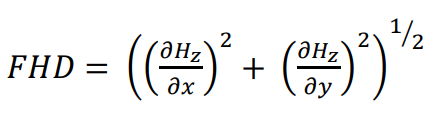

Setelah data ditransformasikan ke sistem koordinat kartesian, kita bisa menghitung nilai turunan orde pertama secara horizontal ke arah sumbu X dan sumbu Y.

In [ ]:
dx = hm.derivative_easting(residual, order=1)
dy = hm.derivative_northing(residual, order=1)

FHD = np.sqrt(dx**2 + dy**2)

Kita petakan nilai FHD.

In [ ]:
fig = pygmt.Figure()
scale = np.quantile(np.abs(FHD), 0.9)
pygmt.makecpt(cmap="seis+h", reverse=True, series=[-scale, scale], background=True)
fig.basemap(projection='X20', region=[lon_min, lon_max, lat_min, lat_max], frame=["WSne", "xaf+lUTMX", "yaf+lUTMY"])
fig.grdimage(grid=FHD, cmap=True)
fig.plot(gdf_coast, pen='1.5p')
fig.plot(gdf_faults, pen='3p')
fig.plot(gdf_thrust, pen='3p')
fig.plot(gdf_subduksi, pen='2p', style="~d1c:+st0.4c+gred+p0.5p,black+n0.1c")
#fig.grdcontour(grid=FHD, levels=0.0001, annotation=0.0001, pen='0.4p')

# Add colorbar
fig.colorbar(frame='af+lPeta First Horizontal Derivative (nT/km)', position="JBC+h+o0/2c+e")
fig.show()

**Download Data FHD**

In [ ]:
# Download file GeoTIFF
FHD = FHD.rename({'easting':'x', 'northing':'y'})
FHD.rio.write_crs("epsg:32747", inplace=True)
FHD_clip = FHD.rio.clip_box(minx=lon_min, miny=lat_min, maxx=lon_max, maxy=lat_max)
FHD = FHD.rename({'x':'easting', 'y':'northing'})

FHD_clip.rio.to_raster("FHD.tiff")
files.download('FHD.tiff')

# Download file CSV
FHD_df = FHD_clip.to_dataframe(name='FHD')
FHD_df.to_csv('FHD.csv')
files.download('FHD.csv')

**6. Second Vertical Derivative**

Selain FHD, metode SVD atau Second Vertical Derivative juga dapat digunakan untuk mendelineasi sumber anomali dan dapat memperjelas pola anomali dari data medan potensial. Second Vertical Derivative (SVD)
dilakukan untuk memunculkan efek dangkal dari pengaruh regionalnya dan
untuk menentukan batas-batas struktur yang ada di daerah penelitian, sehingga filter ini dapat menyelesaikan anomali residual yang tidak mampu dipisahkan dengan metode pemisahan regional-residual yang ada. Secara teoritis, metode ini diturunkan dari persamaan Laplace’s:

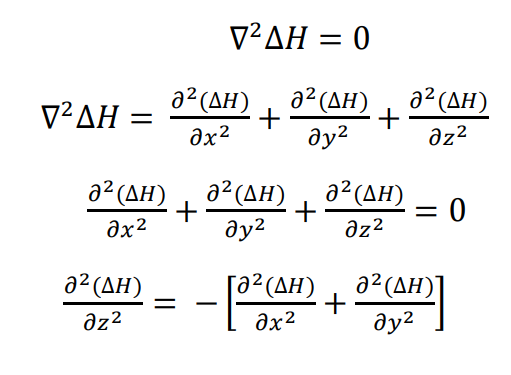

Berdasarkan persamaan diatas, dapat diketahui bahwa nilai SVD dari suatu anomali magnetik permukaan adalah sama dengan negatif dari derivative orde dua horizontalnya. SVD bersifat sebagai highpass filter, sehingga dapat menggambarkan anomali residual yang berasosiasi dengan struktur dangkal.

In [ ]:
dx2 = hm.derivative_easting(residual, order=2)
dy2 = hm.derivative_northing(residual, order=2)

SVD = -(dx2 + dy2)

Kita tampilkan peta SVD.

In [ ]:
fig = pygmt.Figure()
scale = np.quantile(np.abs(SVD), 0.9)
pygmt.makecpt(cmap="seis+h", reverse=True, series=[-scale, scale], background=True)
fig.basemap(projection='X20', region=[lon_min, lon_max, lat_min, lat_max], frame=["WSne", "xaf+lUTMX", "yaf+lUTMY"])
fig.grdimage(grid=SVD, cmap=True)
fig.plot(gdf_coast, pen='1.5p')
fig.plot(gdf_faults, pen='3p')
fig.plot(gdf_thrust, pen='3p')
fig.plot(gdf_subduksi, pen='2p', style="~d1c:+st0.4c+gred+p0.5p,black+n0.1c")
#fig.grdcontour(grid=SVD, levels=0.001, annotation=0.01, pen='0.4p')

# Add colorbar
fig.colorbar(frame='af+lPeta Second Vertical Derivative (nT/km@+2@+)', position="JBC+h+o0/2c+e")
fig.show()

**Download Data SVD**

In [ ]:
# Download file GeoTIFF
SVD = SVD.rename({'easting':'x', 'northing':'y'})
SVD.rio.write_crs("epsg:32747", inplace=True)
SVD_clip = SVD.rio.clip_box(minx=lon_min, miny=lat_min, maxx=lon_max, maxy=lat_max)
SVD = SVD.rename({'x':'easting', 'y':'northing'})

SVD_clip.rio.to_raster("SVD.tiff")
files.download('SVD.tiff')

# Download file CSV
SVD_df = SVD_clip.to_dataframe(name='SVD')
SVD_df.to_csv('SVD.csv')
files.download('SVD.csv')

**7. Tilt Derivative Filter**

Menghitung sudut kemiringan dari grid medan potensial. Menghitung kemiringan dari medan potensial yang tergridded secara teratur. Turunan horizontal dihitung menggunakan metode finite-differences, sedangkan turunan ke atas dihitung menggunakan FFT.

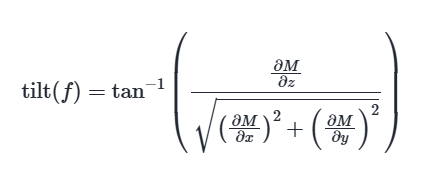

Dimana M adalah data medan potensial.

In [ ]:
# Pad the grid to increase accuracy of the FFT filter
pad_width = {
    "easting": residual.easting.size // 3,
    "northing": residual.northing.size // 3,
}

residual_padded = xrft.pad(residual, pad_width)
TRD = hm.tilt_angle(residual_padded)
TRD = xrft.unpad(TRD, pad_width)

Kita tampilkan peta TRD.

In [ ]:
fig = pygmt.Figure()
scale = np.quantile(np.abs(TRD), 0.995)
pygmt.makecpt(cmap="seis+h", reverse=True, series=[-scale, scale], background=True)
fig.basemap(projection='X20', region=[lon_min, lon_max, lat_min, lat_max], frame=["WSne", "xaf+lUTMX", "yaf+lUTMY"])
fig.grdimage(grid=TRD, cmap=True)
fig.plot(gdf_coast, pen='1.5p')
fig.plot(gdf_faults, pen='3p')
fig.plot(gdf_thrust, pen='3p')
fig.plot(gdf_subduksi, pen='2p', style="~d1c:+st0.4c+gred+p0.5p,black+n0.1c")
#fig.grdcontour(grid=TRD, levels=1, annotation=1, pen='0.4p')

# Add colorbar
fig.colorbar(frame='af+lPeta Tilt Derivative (radian)', position="JBC+h+o0/2c+e")
fig.show()

**Download Data TRD**

In [ ]:
# Download file GeoTIFF
TRD = TRD.rename({'easting':'x', 'northing':'y'})
TRD.rio.write_crs("epsg:32747", inplace=True)
TRD_clip = TRD.rio.clip_box(minx=lon_min, miny=lat_min, maxx=lon_max, maxy=lat_max)
TRD = TRD.rename({'x':'easting', 'y':'northing'})

TRD_clip.rio.to_raster("TRD.tiff")
files.download('TRD.tiff')

# Download file CSV
TRD_df = TRD_clip.to_dataframe(name='TRD')
TRD_df.to_csv('TRD.csv')
files.download('TRD.csv')

**Membuat Irisan Melintang**

Buat slice atau irisan melintang dari data anomali medan magnet residual dengan memasukkan koordinat awal dan akhir dari garis slicenya

In [ ]:
min_lon = 760000
max_lon = 830000
min_lat = 9720000
max_lat = 9760000
lon_inc = 100 # interval sampling longitude
lat_inc = 100 # interval sampling latitude

if min_lon != max_lon:
  x = xr.DataArray(np.arange(min_lon, max_lon, lon_inc).tolist(), dims=['location'])
else:
  x = xr.DataArray([min_lon]*int((max_lat-min_lat)/lat_inc), dims=['location'])

if min_lat != max_lat:
#  y = xr.DataArray(np.arange(min_lat, max_lat, lat_inc).tolist(), dims=['location'])
#else:
  y = xr.DataArray([min_lat]*int((max_lon-min_lon)/lon_inc), dims=['location'])
print(len(x), len(y))
SlicedData = residual.sel(easting=x, northing=y, method='nearest')
SlicedData_FHD = FHD.sel(easting=x, northing=y, method='nearest')
SlicedData_SVD = SVD.sel(easting=x, northing=y, method='nearest')

Tampilkan lokasi garis slice nya

In [ ]:
#########################################
# Peta Anomali residual
fig = pygmt.Figure()
pygmt.makecpt(cmap="seis+h", reverse=True, series=[residual.min().values, residual.max().values], background=True)
fig.basemap(projection='X20', region=[lon_min, lon_max, lat_min, lat_max], frame=True)
fig.grdimage(grid=residual, cmap=True)
#fig.coast(resolution='f', shorelines='2p,black,solid')
fig.grdcontour(grid=residual, interval=20, annotation=20)

fig.plot(x=[min_lon, max_lon], y=[min_lat, max_lat], pen='2p,red')
fig.text(text='A', x=min_lon, y=min_lat, font='14p', offset='0.2/0')
fig.text(text='B', x=max_lon, y=max_lat, font='14p', offset='0.2/0')

# Add colorbar
fig.colorbar(frame='af+lPeta Anomali Medan Magnet Residual (nT)', position="JBC+h+o0/1c+e")
fig.show()

#########################################
# Peta FHD
fig = pygmt.Figure()
pygmt.makecpt(cmap="seis+h", reverse=True, series=[FHD.min().values, FHD.max().values], background=True)
fig.basemap(projection='X20', region=[lon_min, lon_max, lat_min, lat_max], frame=True)
fig.grdimage(grid=FHD, cmap=True)
#fig.coast(resolution='f', shorelines='2p,black,solid')
fig.grdcontour(grid=FHD, interval=0.001, annotation=0.001)

fig.plot(x=[min_lon, max_lon], y=[min_lat, max_lat], pen='2p,red')
fig.text(text='A', x=min_lon, y=min_lat, font='14p', offset='0.2/0')
fig.text(text='B', x=max_lon, y=max_lat, font='14p', offset='0.2/0')

# Add colorbar
fig.colorbar(frame='af+lPeta First Horizontal Derivative (nT/km)', position="JBC+h+o0/1c+e")
fig.show()

#########################################
# Peta SVD
fig = pygmt.Figure()
pygmt.makecpt(cmap="seis+h", reverse=True, series=[SVD.min().values, SVD.max().values], background=True)
fig.basemap(projection='X20', region=[lon_min, lon_max, lat_min, lat_max], frame=True)
fig.grdimage(grid=SVD, cmap=True)
#fig.coast(resolution='f', shorelines='2p,black,solid')
fig.grdcontour(grid=SVD, interval=0.0000001, annotation=0.0000001)

fig.plot(x=[min_lon, max_lon], y=[min_lat, max_lat], pen='2p,red')
fig.text(text='A', x=min_lon, y=min_lat, font='14p', offset='0.2/0')
fig.text(text='B', x=max_lon, y=max_lat, font='14p', offset='0.2/0')

# Add colorbar
fig.colorbar(frame='af+lPeta Second Vertical Derivative (nT/km@+2@+)', position="JBC+h+o0/1c+e")
fig.show()

Buat variabel data, lintang, dan bujur dari data hasil slice

In [ ]:
mag_data = SlicedData.to_numpy()
FHD_data = SlicedData_FHD.to_numpy()
SVD_data = SlicedData_SVD.to_numpy()
lat_data = SlicedData.northing.to_numpy()
lon_data = SlicedData.easting.to_numpy()

Hitung jarak setiap data dari koordinat awal dalam kilometer



In [ ]:
distance = []
for ii in range(len(mag_data)):
    distance += [ii * spacing/1000]

Tampilkan hasil slice

In [ ]:
###########################################
# Slice anomali residual
df = pd.DataFrame({'Jarak': distance, 'Mag': mag_data})

fig = pygmt.Figure()
fig.basemap(projection='X20/10', region=[min(df['Jarak'],), max(df['Jarak'],), min(df['Mag']), max(df['Mag'])],
            frame=["xafg+lJarak (km)",
            "yafg+lAnomali Magnetik (nT)",
            "WSen+tHasil Irisan Melintang Anomali Magnet Residual"])
fig.plot(x=df['Jarak'], y=df['Mag'], pen='2p')
fig.show()

###########################################
# Slice FHD
df_FHD = pd.DataFrame({'Jarak': distance, 'Mag': FHD_data})

fig = pygmt.Figure()
fig.basemap(projection='X20/10', region=[min(df_FHD['Jarak'],), max(df_FHD['Jarak'],), min(df_FHD['Mag']), max(df_FHD['Mag'])],
            frame=["xafg+lJarak (km)",
            "yafg+lFirst Horizontal Derivative (nT/km)",
            "WSen+tHasil Irisan Melintang First Horizontal Derivative"])
fig.plot(x=df_FHD['Jarak'], y=df_FHD['Mag'], pen='2p')
fig.show()

###########################################
# Slice SVD
df_SVD = pd.DataFrame({'Jarak': distance, 'Mag': SVD_data})

fig = pygmt.Figure()
fig.basemap(projection='X20/10', region=[min(df_SVD['Jarak'],), max(df_SVD['Jarak'],), min(df_SVD['Mag']), max(df_SVD['Mag'])],
            frame=["xafg+lJarak (km)",
            "yafg+lSecond Vertical Derivative (nT/km@+2@+)",
            "WSen+tHasil Irisan Melintang Second Vertical Derivative"])
fig.plot(x=df_SVD['Jarak'], y=df_SVD['Mag'], pen='2p')
fig.show()

Simpan data slice anomali residual dalam format ".DAT"

In [ ]:
df.to_csv('slice_residual.dat', sep=',', index=False, lineterminator='\r\n')
files.download('slice_residual.dat')

Simpan data slice FHD dalam format ".DAT"

In [ ]:
df_FHD.to_csv('slice_FHD.dat', sep=',', index=False, lineterminator='\r\n')
files.download('slice_FHD.dat')

Simpan data slice SVD dalam format ".DAT"

In [ ]:
df_SVD.to_csv('slice_SVD.dat', sep=',', index=False, lineterminator='\r\n')
files.download('slice_SVD.dat')

**Referensi**



> Arifin, Y. I. (2019). Kemagnetan Batuan (Anisotropi Batuan Beku). UNG Press Gorontalo.

> Constable, C.G., and Constable, S.C., (2004). Satellite magnetic field measurements: applications in studying the deep earth. In Sparks, R.S.J., and Hawkesworth, C.J., (eds.), The State of the Planet: Frontiers and Challenges in Geophysics. Washington, DC: American Geophysical Union, doi: 10.1029/150GM13, pp. 147–160.

> Fenoglio, M. A., Johnston, M.J.S., dan Byerlee, J.D. (1995). Magnetic and Electric Fields Associated with Changes in High Pore Pressure in Fault Zone-Application to the Loma Prieta ULF Emissions, J. Geophys. Res. 100, pp 12951-12958.

> Freund, F.T. (2007). Pre-Earthquake Signals-Part I: Deviatoric Stresses Turn Rocks into A Source of Electric Currents, Natural Hazards Earth System Science, pp 535-541.

> Hattori, K. (2004). ULF geomagnetic changes associated with large earthquakes, Terr. Atmos. OceanSci., vol. 15,no. 3, pp. 329–360.

> Ismaguilov, V. S., Kopytenko, Yu. A., Hattori, K., and Hayakawa, M. (2003). Variations of phase velocity and gradient values of ULF geomagnetic disturbances connected with the Izu strong earthquakes, Nat. Hazards Earth Syst. Sci., 3, 211–215, https://doi.org/10.5194/nhess-3-211-2003.

> Kolhatkar, A., Jamison, A., Litvinov, D., Willson, R., & Lee, T. (2013). Tuning the Magnetic Properties of Nanoparticles. International Journal of Molecular Sciences, 14(8), 15977–16009. MDPI AG. Retrieved from http://dx.doi.org/10.3390/ijms14081597

> Kopytenko, Y. & Ismagilov, V. & Hayakawa, Masashi & Smirnova, N. & Troyan, V. & Peterson, T.. (2001). Investigation of the ULF electromagnetic phenomena related to earthquakes: Contemporary achievements and the perspectives. Annali di Geofisica. 44. 325-334.

> Merzer, M., dan Klemperer, S.L. (1997). Modelling Low-Frequency Magnetik Field Prekursors to the Loma Prieta Earthquake with A Prekursory Increase in Fault Zone Conductivity, Pure Applied Geophysics, Vol. 150, pp 217-248.

> Molchanov, O.A., dan Hayakawa, M. (1998). On the Generation Mechanism of ULF Seismogenic Emissions, Physics Earth Planet International, Vol. 105, pp 210-210.

> Nettleton, L. L. (1962). Gravity and Magnetics for Geologists and Seismologists. AAPG Bulletin, Vol. 46, No. 10, pp. 1815-1838

> Ravat, D. (2007). Reduction to Pole. In: Gubbins, D., Herrero-Bervera, E. (eds) Encyclopedia of Geomagnetism and Paleomagnetism. Springer, Dordrecht. https://doi.org/10.1007/978-1-4020-4423-6_275

> Santosa, Bagus J., Mashuri, Sutrisno, Wahyu T., Wafi, A., Salim, R., dan Armi, R. (2012). Interpretasi Metode Magnetik untuk Penentuan Struktur Bawah Permukaan di Sekitar Gunung Kelud Kabupaten Kediri. Jurnal Penelitian Fisika dan Aplikasinya (JPFA), Vol. 2 No. 1, Juni 2012. ISSN: 2087-9946.

> Uieda, L., V. C. Oliveira Jr, and V. C. F. Barbosa (2013), Modeling the Earth with Fatiando a Terra, Proceedings of the 12th Python in Science Conference, pp. 91-98. doi:10.25080/Majora-8b375195-010

> Uieda, L., Tian, D., Leong, W. J., Schlitzer, W., Grund, M., Jones, M., Fröhlich, Y., Toney, L., Yao, J., Magen, Y., Tong, JH., Materna, K., Belem, A., Newton, T., Anant, A., Ziebarth, M., Quinn, J., and Wessel, P. (2023). PyGMT: A Python interface for the Generic Mapping Tools (Version 0.9.0). doi:10.5281/zenodo.7772533